# High and low of PyData

The wonderful PyData stack and a gentle intro

![Mobify](https://www.mobify.com/wp-content/themes/sparkjoy-mobify-may-16-v2/library/images/logo-mobify-spark-sm-black.png)

## Hello

* Started as a reverse engineer
* Founded a startup Pathful - Python full stack
* Now part of Mobify - plays with Python Data Pipeline!

In [11]:
import dis
import django
import numpy, pandas

In [12]:
from __future__ import print_function, division

# PyData stack

What is PyData?

### ![Stack diagram](http://image.slidesharecdn.com/pydatanyc2015-151110132252-lva1-app6891/95/pydata-nyc-2015-3-638.jpg?cb=1447161910)


![img](https://raw.githubusercontent.com/sketchytechky/PyData-Intro/master/pydata_stack.jpg)

### Each part of the python stack

* Platform - IPython
* Packaging - Conda
* Visualization - Bokeh, matplotlib for 
* Model - Statsmodel, Scipy, PyMC, NetworkX and SKLearn
* Data access - Pandas, Blaze, numpy
* Voodo - numba

## Platform - IPython

![jupyer](http://jupyter.org/assets/nav_logo.svg)

* A place which allows you to play with data
* share your result - e.g. this presentation



In [206]:
# Look, you can live code in here
from sklearn import datasets
# import some data to play with
iris = datasets.load_iris()
#print(iris.DESCR)

## Packaging - Conda

* Package and environment management system
* Specialize in compiling different binary packages
* Especially useful for PyData packages since they takes a long time to build
* Automatic take advantage of some hardware optimization (e.g. Intel MKL)



## Visualiztion - Bokeh

* Very easy to do visualization inside the notebook


In [115]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [207]:
from bokeh.charts import show
# a hack to prevent showing import error
def show_wrapper(scatter):
    try:
        show(scatter)
    except ImportError:
        pass

In [208]:
from bokeh.charts import Scatter, output_file, show
from bokeh.sampledata.iris import flowers as data

scatter = Scatter(data, x='petal_length', y='petal_width',
                  color='species', marker='species',
                  title='Iris Dataset Color and Marker by Species',
                  legend=True)

output_file("iris_simple.html", title="iris_simple.py example")

show_wrapper(scatter)

# "Model" layer
* aka the `import make_me_smart` layer
* e.g. Statsmodel, Scipy, PyMC, NetworkX and SKLearn
* Make a bunch of tricky operation easy! (e.g. SVM)

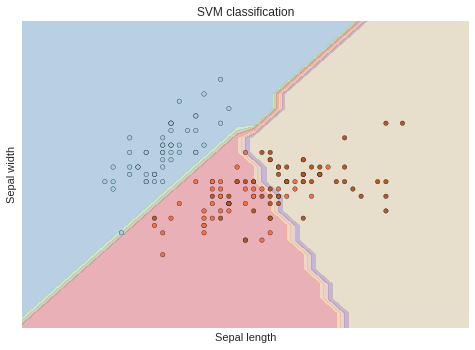

In [169]:
# http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1.0)

from bokeh.sampledata.iris import flowers as data


X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

svc.fit(X, y) 


# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("SVM classification")


## Data Access layer

* Pandas / Numpy
* Very efficient multi-dimension
* Store data within continous space, instead of chain list
* Many optimization librarys underneath - e.g. uses BLAS (http://www.netlib.org/blas/) or Intel Math Kernel Library (https://software.intel.com/en-us/intel-mkl)

![language](https://snag.gy/9Bip8G.jpg)




In [13]:
# https://code.activestate.com/recipes/577504/

from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print (s, type(o), repr(o))

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)



In [14]:
# Generate a multi-dimension array
input_3d_array = [[[range(10) for _ in range(10)] for _ in range(10)] for _ in range(10)]

print("Size in array: {}".format(total_size(input_3d_array)))
print("Size of numpy: {}".format(total_size(np.array(input_3d_array))))

Size in array: 174440
Size of numpy: 80144


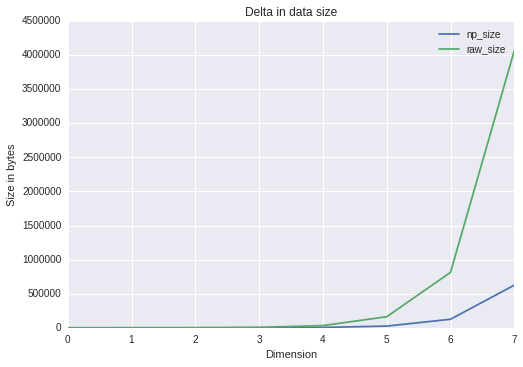

In [184]:
sizes = []
for i in range(8):
    arr = np.ones([5] * i)
    sizes.append({
        'raw_size' : total_size(arr.tolist()),
        'np_size' : total_size(arr)
        })

plt.figure()
ax = pd.DataFrame(sizes).plot(title="Delta in data size")
plt.xlabel('Dimension')
plt.ylabel('Size in bytes')


## Voodo - Low level optimization

* Numba is very good at that!
* Compile python into llvm - which then compile into native code
* Example: Fast fourier transform - https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/

In [18]:
# Install nufft from http://github.com/dfm/python-nufft/
from nufft import nufft1 as nufft_fortran

from time import time

import numpy as np

def nufftfreqs(M, df=1):
    """Compute the frequency range used in nufft for M frequency bins"""
    return df * np.arange(-(M // 2), M - (M // 2))


def nudft(x, y, M, df=1.0, iflag=1):
    """Non-Uniform Direct Fourier Transform"""
    sign = -1 if iflag < 0 else 1
    return (1 / len(x)) * np.dot(y, np.exp(sign * 1j * nufftfreqs(M, df) * x[:, np.newaxis]))

def _compute_grid_params(M, eps):
    # Choose Msp & tau from eps following Dutt & Rokhlin (1993)
    if eps <= 1E-33 or eps >= 1E-1:
        raise ValueError("eps = {0:.0e}; must satisfy "
                         "1e-33 < eps < 1e-1.".format(eps))
    ratio = 2 if eps > 1E-11 else 3
    Msp = int(-np.log(eps) / (np.pi * (ratio - 1) / (ratio - 0.5)) + 0.5)
    Mr = max(ratio * M, 2 * Msp)
    lambda_ = Msp / (ratio * (ratio - 0.5))
    tau = np.pi * lambda_ / M ** 2
    return Msp, Mr, tau

def test_nufft(nufft_func, M=1000, Mtime=100000):
    # Test vs the direct method
    print(30 * '-')
    name = {'nufft1':'nufft_fortran'}.get(nufft_func.__name__,
                                          nufft_func.__name__)
    print("testing {0}".format(name))
    rng = np.random.RandomState(0)
    x = 100 * rng.rand(M + 1)
    y = np.sin(x)
    for df in [1, 2.0]:
        for iflag in [1, -1]:
            F1 = nudft(x, y, M, df=df, iflag=iflag)
            F2 = nufft_func(x, y, M, df=df, iflag=iflag)
            assert np.allclose(F1, F2)
    print("- Results match the DFT")
    
    # Time the nufft function
    x = 100 * rng.rand(Mtime)
    y = np.sin(x)
    times = []
    for i in range(5):
        t0 = time()
        F = nufft_func(x, y, Mtime)
        t1 = time()
        times.append(t1 - t0)
    print("- Execution time (M={0}): {1:.2g} sec".format(Mtime, np.median(times)))
 

In [19]:

def nufft_python(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Python"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = np.zeros(Mr, dtype=c.dtype)
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    mm = np.arange(-Msp, Msp)
    for i in range(N):
        xi = (x[i] * df) % (2 * np.pi)
        m = 1 + int(xi // hx)
        spread = np.exp(-0.25 * (xi - hx * (m + mm)) ** 2 / tau)
        ftau[(m + mm) % Mr] += c[i] * spread

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau
 

In [20]:
test_nufft(nufft_python)
test_nufft(nufft_fortran)

------------------------------
testing nufft_python
- Results match the DFT
- Execution time (M=100000): 1.3 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.043 sec


In [209]:
from numba import jit

@numba.jit(nopython=True)
def build_grid_fast(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in range(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau


def nufft_numba_fast(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Numba"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = build_grid_fast(x * df, c, tau, Msp,
                           np.zeros(Mr, dtype=c.dtype),
                           np.zeros(Msp + 1, dtype=x.dtype))

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

In [72]:
from numba.pycc import CC

cc = CC('fft')
# Uncomment the following line to print out the compilation steps
#cc.verbose = True

@cc.export('add_int', 'i8[:](i8[:])')
def add_int(x):
    return x + 0xcafebabe


@cc.export('build_grid_fast', 'f8[:](f8[:], f8[:], f8, i8, f8[:], f8[:])')
def build_grid_fast(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in range(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau

cc.compile() 

## It is fast!

Comparable to Fotran speed

In [124]:
test_nufft(nufft_python)
test_nufft(nufft_numba_fast)
test_nufft(nufft_fortran)

------------------------------
testing nufft_python
- Results match the DFT
- Execution time (M=100000): 1.3 sec
------------------------------
testing nufft_numba_fast
- Results match the DFT
- Execution time (M=100000): 0.063 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.041 sec


The `_pycc_method_build_grid_fast` function - 2752 bytes

In [55]:
!objdump -D fft.so > fft.dasm

In [107]:
!grep -A200 00004180.*_pycc_method_build_grid_fast  fft.dasm

0000000000004180 <._pycc_method_build_grid_fast>:
    4180:	55                   	push   %rbp
    4181:	41 57                	push   %r15
    4183:	41 56                	push   %r14
    4185:	41 55                	push   %r13
    4187:	41 54                	push   %r12
    4189:	53                   	push   %rbx
    418a:	48 81 ec 58 02 00 00 	sub    $0x258,%rsp
    4191:	48 89 fb             	mov    %rdi,%rbx
    4194:	48 8d 84 24 28 02 00 	lea    0x228(%rsp),%rax
    419b:	00 
    419c:	48 89 44 24 18       	mov    %rax,0x18(%rsp)
    41a1:	48 8d 84 24 30 02 00 	lea    0x230(%rsp),%rax
    41a8:	00 
    41a9:	48 89 44 24 10       	mov    %rax,0x10(%rsp)
    41ae:	48 8d 84 24 38 02 00 	lea    0x238(%rsp),%rax
    41b5:	00 
    41b6:	48 89 44 24 08       	mov    %rax,0x8(%rsp)
    41bb:	48 8d 84 24 40 02 00 	lea    0x240(%rsp),%rax
    41c2:	00 
    41c3:	48 89 04 24          	mov    %rax,(%rsp)
    41c7:	48 8d 2d 4f 8e 00 00 	lea    0x8e4f(%rip),%rbp        # d01d <.const.build_grid_f

In [101]:
!grep -B100 -A100 cafebabe fft.dasm

    3f10:	b8 01 00 00 00       	mov    $0x1,%eax
    3f15:	f0 48 0f c1 07       	lock xadd %rax,(%rdi)
    3f1a:	48 ff c0             	inc    %rax
    3f1d:	c3                   	retq   
    3f1e:	66 90                	xchg   %ax,%ax

0000000000003f20 <nrt_atomic_sub>:
    3f20:	48 c7 c0 ff ff ff ff 	mov    $0xffffffffffffffff,%rax
    3f27:	f0 48 0f c1 07       	lock xadd %rax,(%rdi)
    3f2c:	48 ff c8             	dec    %rax
    3f2f:	c3                   	retq   

0000000000003f30 <nrt_atomic_cas>:
    3f30:	48 89 f0             	mov    %rsi,%rax
    3f33:	f0 48 0f b1 17       	lock cmpxchg %rdx,(%rdi)
    3f38:	0f 94 c2             	sete   %dl
    3f3b:	48 89 01             	mov    %rax,(%rcx)
    3f3e:	0f b6 c2             	movzbl %dl,%eax
    3f41:	c3                   	retq   
    3f42:	66 66 66 66 66 2e 0f 	data16 data16 data16 data16 nopw %cs:0x0(%rax,%rax,1)
    3f49:	1f 84 00 00 00 00 00 

0000000000003f50 <NRT_MemInfo_data_fast>:
    3f50:	48 8b 47 18          	mov    0x18

## Take a simple function


In [ ]:
@cc.export('add_int', 'i8[:](i8[:])')
def add_int(x):
    return x + 0xcafebabe

* `add_int` become just a 22 bytes loop (whole function size = 496 bytes)

```
    4070:	mov    0x0(%rbp),%rsi
    4074:	add    %rax,%rsi  ; %rax = 0xcafebabe
    4077:	mov    %rsi,(%rcx)
    407a:	add    $0x8,%rbp
    407d:	add    $0x8,%rcx
    4081:	dec    %rdx    ; %rdx is array counter
    4084:	jne    4070 <._pycc_method_add_int+0xe0>
    4086:	jmp    40a3 <._pycc_method_add_int+0x113>
 ```

## What is PyData is good at?

Let's compare to the Apache Data stack

![bigdata](https://raw.githubusercontent.com/sketchytechky/PyData-Intro/master/apache_stack.jpg)



![image](https://raw.githubusercontent.com/sketchytechky/PyData-Intro/master/scaleup_out.jpg)

## What PyData goods at: Scaling Up


A PyData shaped problem:
* Problem that data can hold in memory space.
* Especially arrays - large table, high dimension tables


But.... if it doesnt fit:
* There're a glue layer utilizing best of both world
  - hadoop streaming
  - pysparks, pyflink


## Good pattern: *Scale up before scale out*

Scale up is easier than scaling out:
* Cost associated with "parallelizing" an algorithm (e.g. SVM)
* Devops cost involve in distributing



## Future: Scale out in Python

![UpVOut](http://image.slidesharecdn.com/scaleupscaleout-160314201333/95/scale-up-and-scale-out-anaconda-and-pydata-4-638.jpg?cb=1457986501)


## Please try it out!

* Easy to get started
   - Anaconda https://www.continuum.io/downloads
* All layer of your data need is support out of one install


# Thanks

Questions?

https://github.com/sketchytechky/PyData-Intro/